# Quantum Phase Estimation

## The circuit

We have a goal: given a unitary operator $U$, we want to estimate $\theta$ from $U|\psi \rangle = e^{2\pi\theta}|\psi \rangle$.

Notice that in this case $|\psi \rangle$ is an eigenvector of eigenvalue $e^{2\pi\theta}$. Since $U$ is unitary, every eigenvalue has norm $1$.

We will use three qubits as *counting qubits*, and a fourth one as eigenstate of the unitary operator $T$.
We initialize the last one in $|1 \rangle$ by applying the $X$ gate.

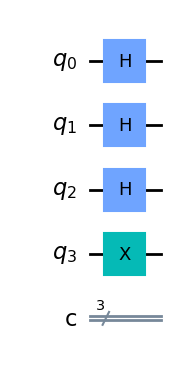

In [1]:
from qiskit import QuantumCircuit

qpe_circuit = QuantumCircuit(4, 3)
for qbit in range(3):
    qpe_circuit.h(qbit)
qpe_circuit.x(3)
qpe_circuit.draw(output='mpl')

Now we want to perform controlled unitary operations

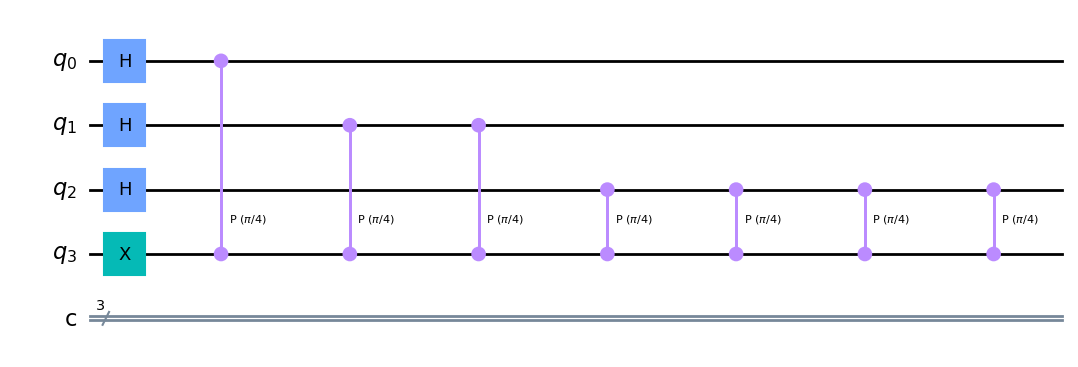

In [2]:
import numpy as np

repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe_circuit.cp(np.pi/4, counting_qubit, 3) # This is the Controlled U gate
    repetitions *= 2
qpe_circuit.draw(output='mpl')

Now we apply the **Inverse Quantum Fourier Transform** in order to convert the counting register state.

The code for the IQFT is:

In [3]:
def iqft(qCircuit, n):
    '''
    Apply the inverse quantum Fourier transform to the first n qubits in qCircuit
    '''
    for qubit in range(n//2):
        qCircuit.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qCircuit.cp(-np.pi/float(2**(j-m)), m, j)
        qCircuit.h(j)

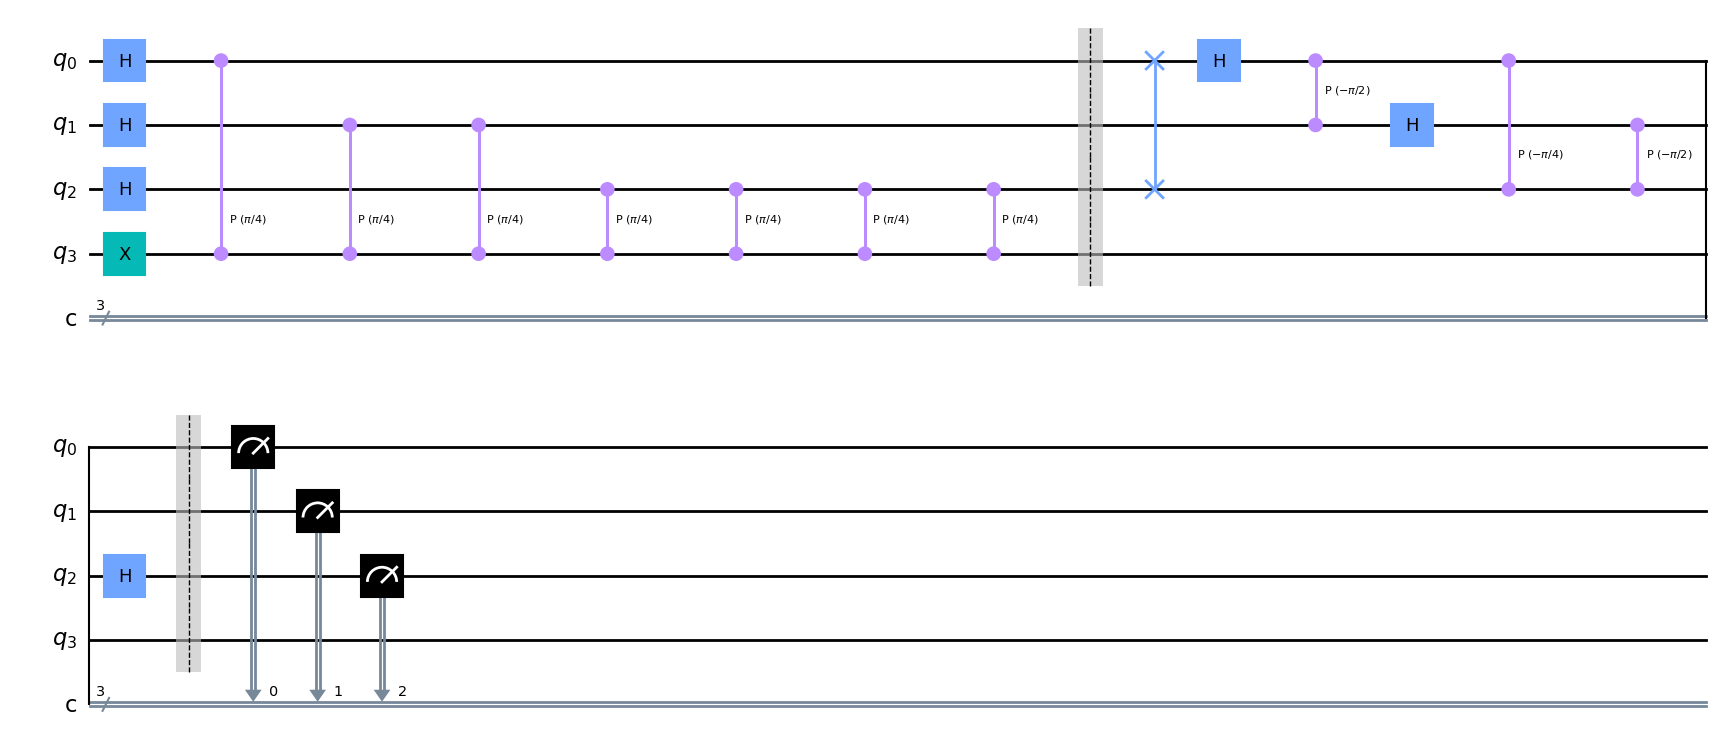

In [4]:
qpe_circuit.barrier()
iqft(qpe_circuit, 3)
qpe_circuit.barrier()

for n in range(3):
    qpe_circuit.measure(n,n)

qpe_circuit.draw(output='mpl')

## Simulate the IQFT

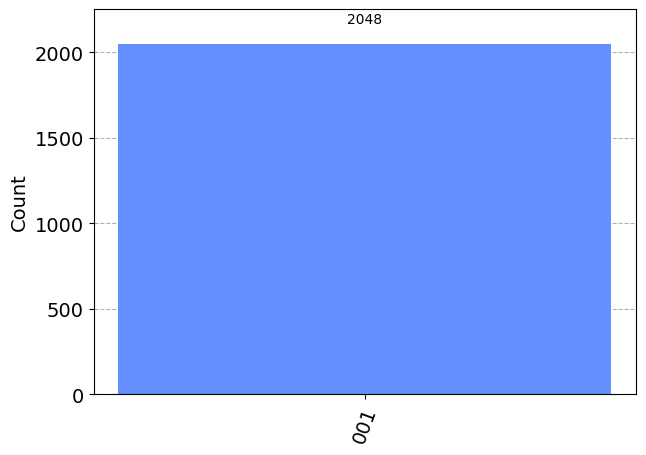

In [5]:
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram

simulator = Aer.get_backend('aer_simulator')
N = 2**11
t_qpe = transpile(qpe_circuit, simulator)

result = simulator.run(t_qpe, shots=N).result()
plot_histogram(result.get_counts())

Notice that we always get $(001)$ as result: it translates into decimal $1$.

In order to get $\theta$ we need to divide our result by $2^n$, i.e.
$$
\theta = \frac{1}{2^3} = \frac{1}{8}
$$
as expected.

## Increasing precision

We may use, instead of a $T$-gate, a gate with $\theta = \frac{1}{3}$.

In [6]:
def build_qpe(qubits, bits):
    # Create and set up circuit
    qpe = QuantumCircuit(qubits, bits)

    # Apply H-Gates to counting qubits:
    for qubit in range(bits):
        qpe.h(qubit)

    # Prepare our eigenstate |psi>:
    qpe.x(bits)

    # Do the controlled-U operations:
    angle = 2*np.pi/3
    repetitions = 1
    for counting_qubit in range(bits):
        for i in range(repetitions):
            qpe.cp(angle, counting_qubit, bits);
        repetitions *= 2

    # Do the inverse QFT:
    iqft(qpe, bits)

    # Measure of course!
    for n in range(bits):
        qpe.measure(n,n)
    
    return qpe

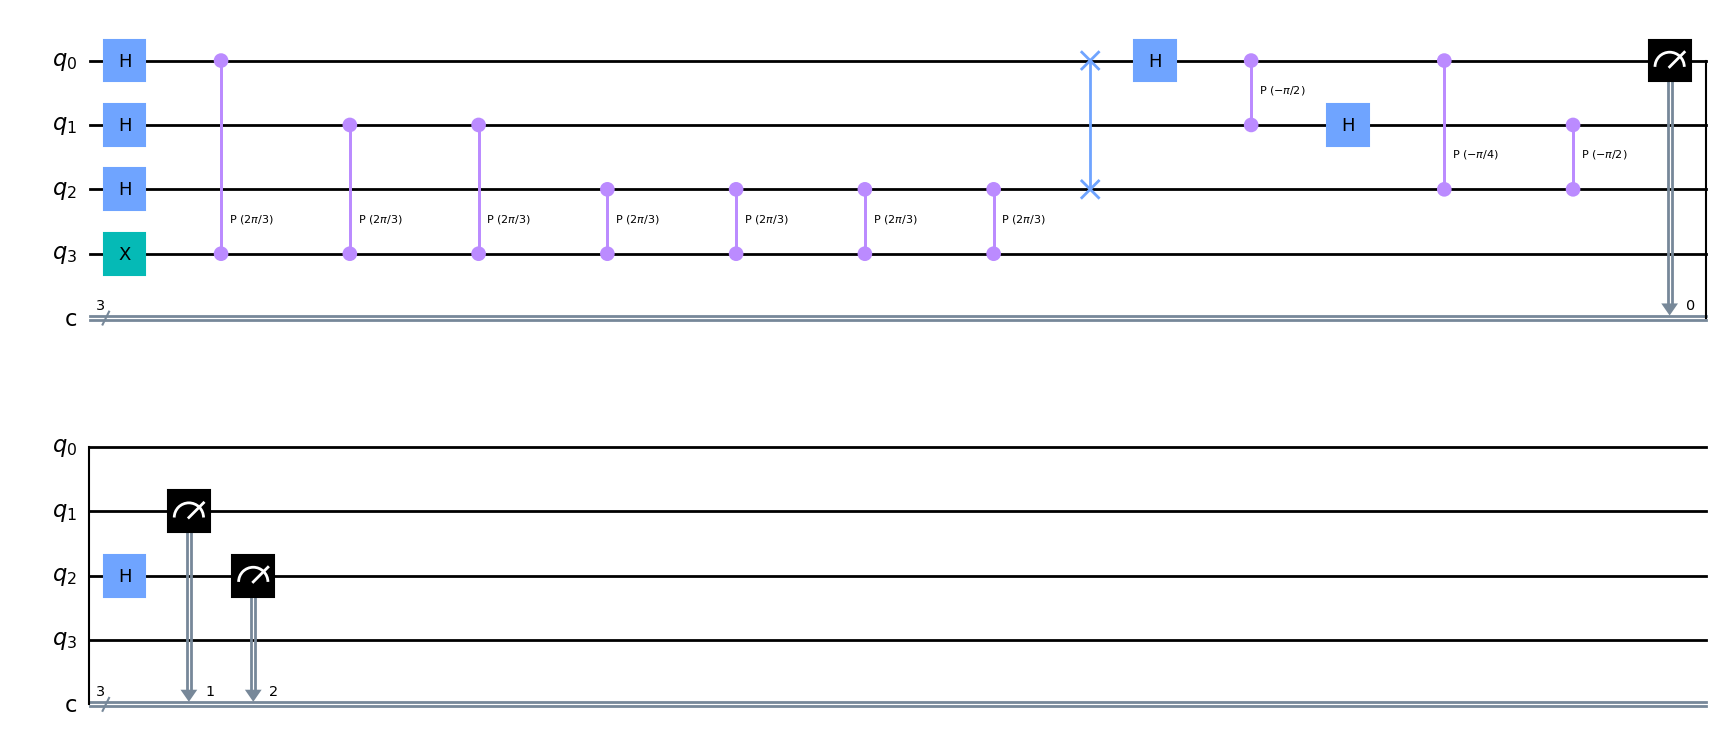

In [7]:
qpe_circuit = build_qpe(4, 3)
qpe_circuit.draw(output='mpl')

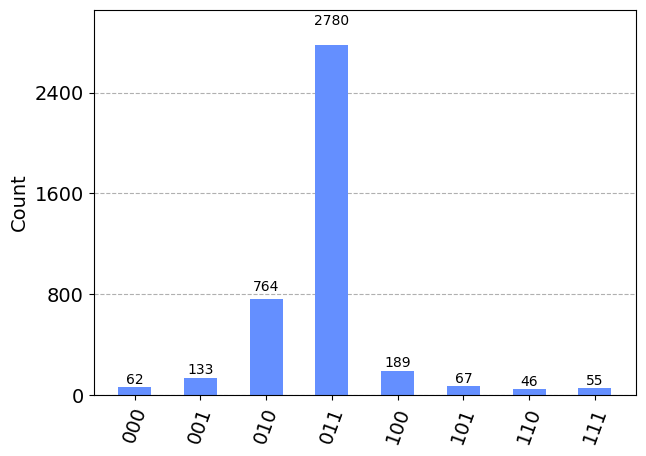

In [8]:
simulator = Aer.get_backend('aer_simulator')
N = 2**12
t_qpe = transpile(qpe_circuit, simulator)
results = simulator.run(t_qpe, shots=N).result()
plot_histogram(results.get_counts())

We expect as result $\theta = 0.333...$.
We see that the most likely results are $(010)$ = $2$ and $(011)$ = $3$, which imply $\theta = 0.25$ or $\theta = 0.375$.
The true value lies between two of our possible values... how to solve this problem?

Well we can, for instance, add more counting qubits:

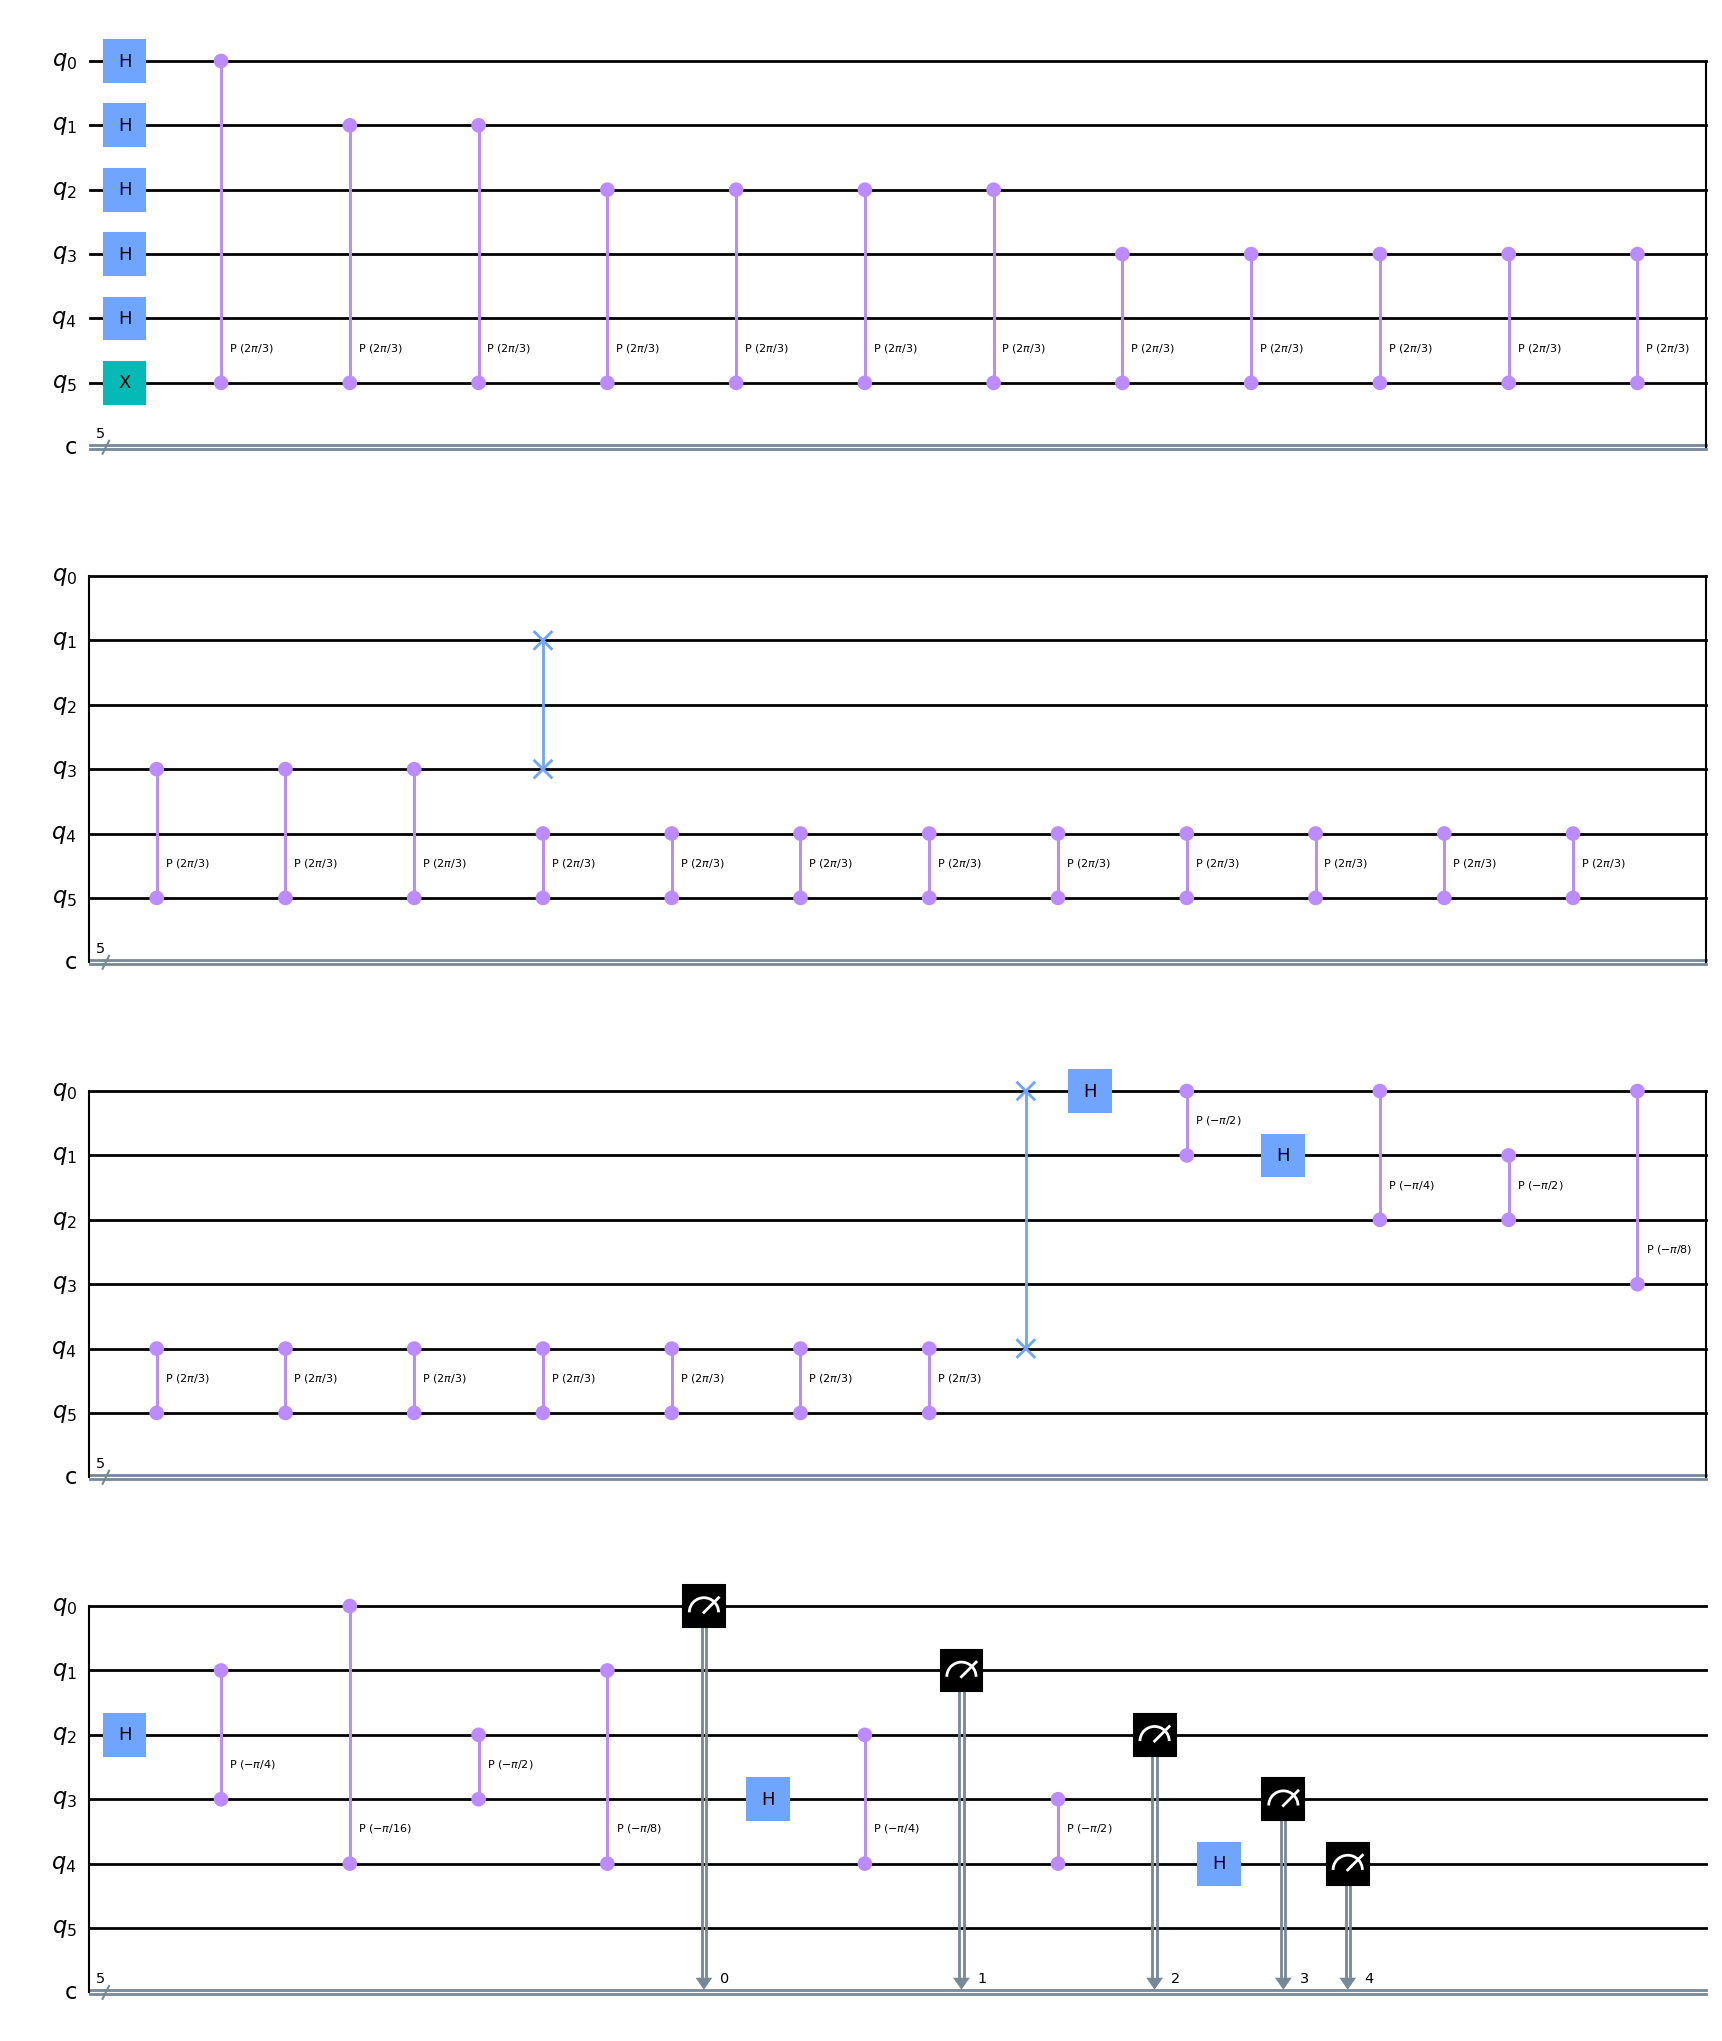

In [9]:
qpe_circuit = build_qpe(6, 5)
qpe_circuit.draw(output='mpl')

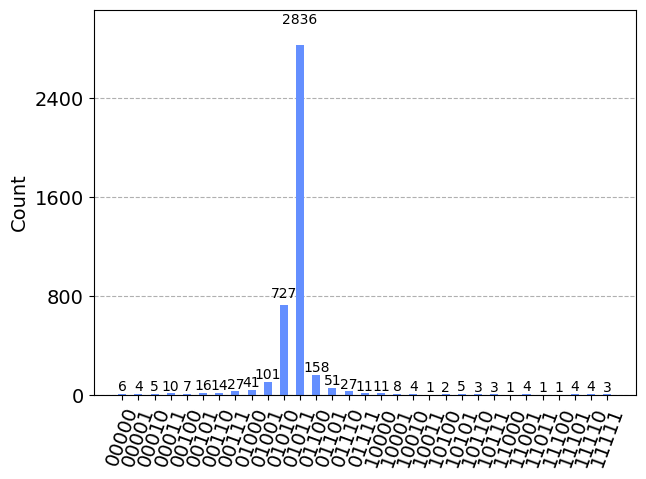

In [10]:
simulator = Aer.get_backend('aer_simulator')
N = 2**12
t_qpe = transpile(qpe_circuit, simulator)
results = simulator.run(t_qpe, shots=N).result()
plot_histogram(results.get_counts())

Now we measure $(01011)$ = $11$ and $(01010)$ = $10$.
So
$$
    \theta = \frac{11}{2^5} = 0.34 \ \ \ \ \text{or} \ \ \ \ \theta = \frac{10}{2^5} = 0.31
$$
and the precision has been increased.

## Phase estimation on a Real Device

Now we want to reproduce on the IBM device the previous circuit.
In order to do it we need to install 

`pip install qiskit-ibm-runtime`

First, we try it without error correction.

In [11]:
from qiskit_ibm_runtime import QiskitRuntimeService

with open('token.txt', 'r') as f:
    APItoken = f.read()

QiskitRuntimeService.save_account(
    channel='ibm_quantum', token=APItoken, overwrite=True)

service = QiskitRuntimeService(channel="ibm_quantum")

backend = service.backend("ibmq_qasm_simulator")  # or ibmq_lagos

In [12]:
from qiskit_ibm_runtime import Sampler, Options

options = Options()
options.resilience_level = 0
options.execution.shots = 2**11

sampler = Sampler(backend=backend, options=options)

job = sampler.run(qpe_circuit)

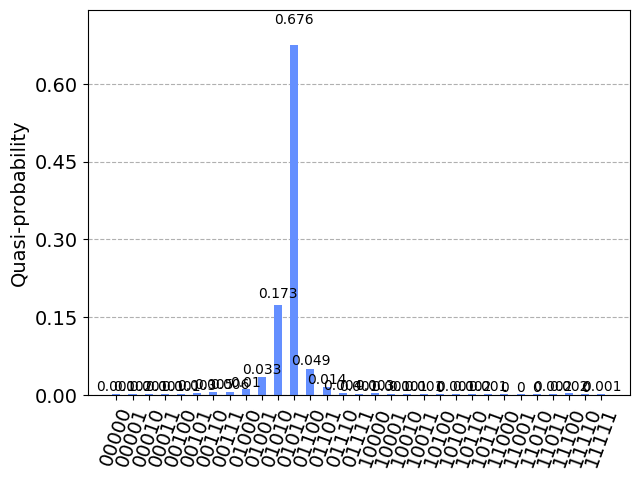

In [14]:
from qiskit.visualization import plot_distribution

result = job.result()

# Collect quasiprobability distribution
distribution = result.quasi_dists[0].binary_probabilities()
plot_distribution(distribution)

Then we try to mitigate error by using [T-REx mitigation](https://qiskit.org/ecosystem/ibm-runtime/tutorials/Error-Suppression-and-Error-Mitigation.html#Twirled-readout-error-extinction), which stands for Twirled Readout Error extinction.

In [16]:
options = Options()
options.resilience_level = 1  # T-REx mitigation
options.execution.shots = 2**11

sampler = Sampler(backend=backend, options=options)

job = sampler.run(qpe_circuit)
print(f">>> Job Status: {job.status()}")

>>> Job Status: JobStatus.RUNNING


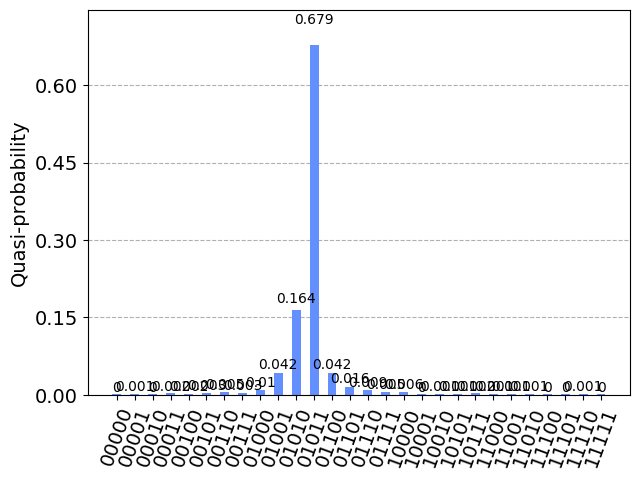

In [17]:
result = job.result()

# Collect quasiprobability distribution
distribution = result.quasi_dists[0].binary_probabilities()
plot_distribution(distribution)